
# Transferencia de Aprendizaje

Una de las ventajas del DL es el uso de modelos preentrenados para resolver tareas nuevas, tareas para las cuales la ANN no fue entrenada inicialmente.
Esto es posible dado que en cada capa de la ANN se aprenden diferentes características con diferentes niveles de abstracción. La ANN se puede cortar en cualquier capa y utilizar los pesos aprendidos hasta esa capa. A la capa cortada se le pueden anexar nuevas capas. Posteriormente se entrena el modelo con los nuevos datos. Este entrenamiento es más rápido pues inicia desde un punto avanzado y no desde cero. Esta técnica se conoce como transferencia de aprendizaje (**transfer learning**). 

![](https://drive.google.com/uc?id=1GehRE6XF75ufwlyRAP5YmrDY2gV839rq)
Sebastian Ruder, "Transfer Learning - Machine Learning's Next Frontier". http://ruder.io/transfer-learning/, 2017.

<br>

El *Transfer Learning* es un método de optimización, un atajo para ahorrar tiempo y obtener mejores resultados, pues se suelen utilizar modelos entrenados con grandes datasets, que continen alta cantidad de clases y variabilidad de datos.

<br>

Este método tiene tres grandes ventajas:

* **Inicio avanzado**. La capacidad inicial en el modelo de origen (antes de refinar el modelo) es mayor de lo que sería iniciando desde cero.
* **Pendiente más alta**. La tasa de precisión durante el entrenamiento del modelo es más pronunciada.
* **Asíntota superior**. La tasa de convergencia del modelo entrenado es mejor. 


# Ejercicio

En este notebook utilizaremos el mecanismo de *Transferencia de Aprendizaje* para clasificar imágenes.

# Cargando un modelo pre-entrenado

Para nuestro ejercicio usaremos ResNet18, una red Red Neuronal Convolucional con 18 capas de profundidad. Recordemos que el nombre de **Residual-Net** proviene de la estrategia de usar conexiones de salto residualmente dentro de bloques (llamados bloques residuales, ver Figura), donde la entrada *x* se agrega directamente a la salida del bloque, es decir, *F(x) + x* garantizando el aumento en la profundidad de la red al omitir ciertas capas utilizando conexiones de omisión o bloques residuales. Un gran avance para el problema de optimización/degradación con redes profundas.
[Paper de presentación de ResNet](https://arxiv.org/pdf/1512.03385.pdf).

![](https://drive.google.com/uc?id=1L4pWbh0zANQQz-8oLruKhwmyITm2UWdK)

<br>

El modelo pre-entrenado puede clasificar imágenes en al menos 1000 categorías diferentes, tal como teclado, mouse, lápiz y diferentes clases de animales. Dada la variedad de objetos en el dataset de entrenamieto el modelo es rico en representación de features en un alto rango de clases. ResNet fue entrenado con [Imagenet](https://image-net.org/) un gigantesco dataset visual diseñado para el uso de proyectos en reconocimiento de objetos. Imagenet tiene al menos 14 millones de imágenes anotadas. La entrada de la red tiene un tamaño de 224x224x3.



# Cargando los Datos

In [ ]:
#-- Descomprimimos el dataset
# !rm -r mnist
# !unzip /content/drive/MyDrive/Colab/IntroDeepLearning_202102/mnist.zip

In [ ]:
#--- Buscamos las direcciones de cada archivo de imagen
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

#--- Ordenamos los datos de forma aleatoria para evitar sesgos
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

'./mnist/train/4/8264.png'

Al momento de cargar los datos es necesario reescalarlos al tamaño de entrada del modelo reciclado en este caso (224,224,3). Es necesario reescalar y normalizar las imágenes (La normalización se hace usando la media y la desviación estándar). La normalización ayuda a la red a converger más rápido.

In [ ]:
import torchvision.transforms as transforms

#--- Transformamos los datos para adaptarlos a la entrada de ResNet 224x224 px
data_transform = transforms.Compose([
                 transforms.Resize((224, 224)),
                 transforms.Grayscale(3), #Dado que MNIST tiene un solo canal, lo cambiamos a 3 para no tener que modificar más capas en el modelo
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                 ])

In [ ]:
#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append( np.array(data_transform(Image.open(train_file) )))

In [ ]:
#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(data_transform(Image.open(test_file)) ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


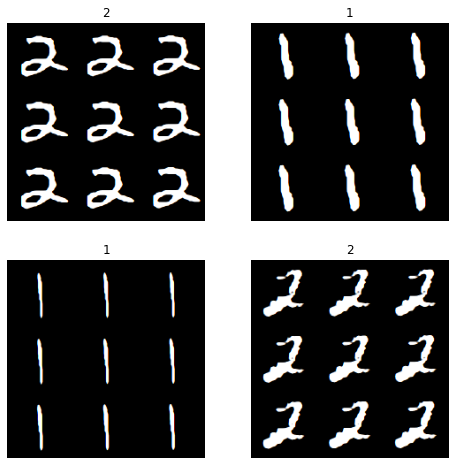

In [ ]:
#-- Visualizamos los datos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15].reshape(224,224,3))
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [ ]:
#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 3, 224, 224])

In [ ]:
#-- Creamos el DataLoader

batch_size = 32

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# Entrenando el modelo

In [ ]:
#--- Seleccionamos y cargamos el modelo
import torch

model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
model

Using cache found in /root/.cache/torch/hub/pytorch_vision_master


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#--- Congelamos los pesos en las capaz del modelo para que no se actualicen
for p in model.parameters():
    p.requires_grad = False

#--- Definimos el número de clases
out_dim = 10

#--- Reescribimos la nueva capa de salida con el nuevo dataset
model.fc = torch.nn.Sequential(
  torch.nn.Linear(model.fc.in_features, out_dim)
)


model.load_state_dict(model.state_dict())

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
!pip install hiddenlayer

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


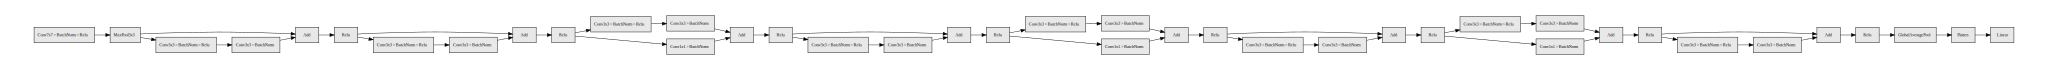

In [ ]:
#--- Visualizamos la estructura de nuestra CNN

import hiddenlayer as hl

hl.build_graph(model, torch.zeros([64,3,264,264]))

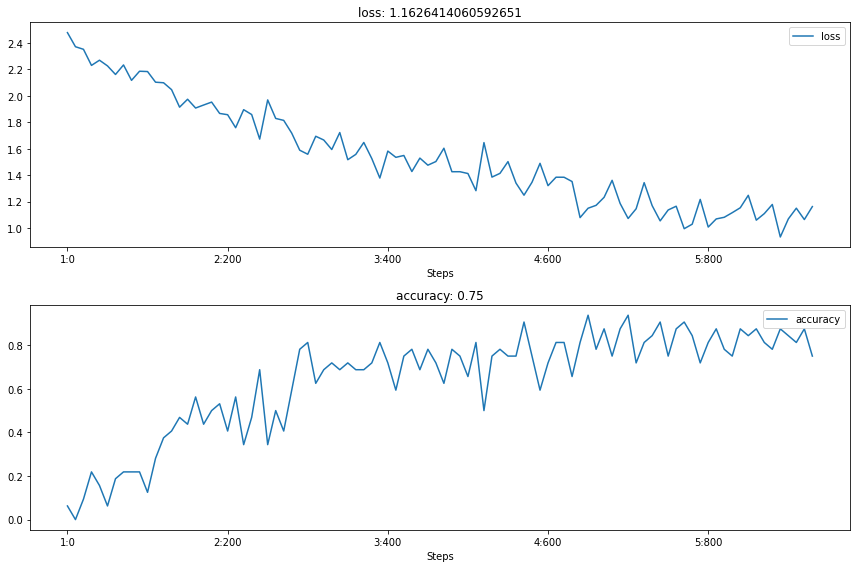

In [ ]:
#--- Creamos variables para almacenar los scores en cada época 

model = model.cuda()

model.train()

#--- Definimos nuestro criterio de evaluación y el optimizador 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.1)
criterion = torch.nn.CrossEntropyLoss()


#--- Entrenamos el modelo usando únicamente 5 épocas
n_epochs = 5

history = hl.History()
canvas = hl.Canvas()

iter = 0

for epoch in range(n_epochs):
  for batch_idx, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    # Pasamos os datos a 'cuda'
    
    X_train_batch = X_train_batch.cuda()
    Y_train_batch = Y_train_batch.cuda()

    # Realiza una predicción
    Y_pred = model(X_train_batch)

    # Calcula el loss
    loss = criterion(Y_pred, Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)

    # Calcula el accuracy
    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter%10 == 0:
        #-- Visualizamos la evolución de los score loss y accuracy
        history.log((epoch+1, iter), loss=loss, accuracy=acc)
        with canvas:
          canvas.draw_plot(history["loss"])
          canvas.draw_plot(history["accuracy"])

    iter += 1
    del X_train_batch, Y_train_batch, Y_pred

In [ ]:
#-- Validamos el modelo
from sklearn.metrics import f1_score

model.cpu()
model.eval()

Y_pred = model(X_test)
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

Loss:1.05, F1:0.82, Acc:0.83


In [ ]:
#--- Guardamos el nuevo Modelo
torch.save(model,open('./ResNet_MNIST.pt','wb'))

In [ ]:
from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes, lclasses=None):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  if lclasses == None:
    lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

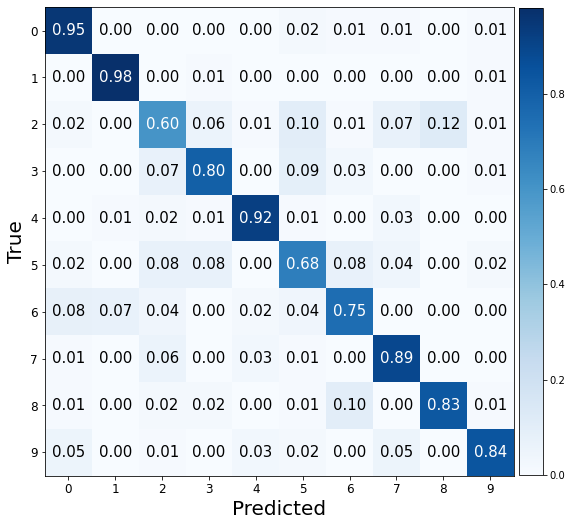

In [ ]:
CM(Y_test, Y_pred, 10)